In [33]:
!pip install ortools pandas

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ortools.sat.python import cp_model

In [34]:
n_drivers = 20 #motoristas, colocar até 100
n_demands = 10 #demandas, colocar até 100
time_limit_sec = 2

# Para repetibilidade
np.random.seed(0)

#coordenadas aleatórias para motoristas e demandas no intervalo [0, 100] × [0, 100]
driver_coords = np.random.uniform(0, 100, size=(n_drivers, 2))
demand_coords = np.random.uniform(0, 100, size=(n_demands, 2))

#IDs simples
driver_ids = [f"D{i+1}" for i in range(n_drivers)]
demand_ids = [f"J{j+1}" for j in range(n_demands)]

In [35]:
#custos c[(i_id, j_id)] = distância euclidiana
c = {}
for i, did in enumerate(driver_ids):
    for j, jid in enumerate(demand_ids):
        c[(did, jid)] = np.hypot(driver_coords[i,0] - demand_coords[j,0],
                                 driver_coords[i,1] - demand_coords[j,1])

In [36]:
def solve_assignment_cpsat(sub_I, sub_J, c_dict, time_limit_sec):
    model = cp_model.CpModel()
    # Variáveis x[i,j]
    x = {(i,j): model.NewBoolVar(f"x_{i}_{j}") for i in sub_I for j in sub_J}
    # Cada demanda atendida por exatamente 1 motorista
    for j in sub_J:
        model.Add(sum(x[(i,j)] for i in sub_I) == 1)
    # Cada motorista atende no máximo 1 demanda
    for i in sub_I:
        model.Add(sum(x[(i,j)] for j in sub_J) <= 1)
    # Objetivo: minimizar soma c[i,j] * x[i,j]
    terms = []
    for i in sub_I:
        for j in sub_J:
            terms.append(int(round(c_dict[(i,j)]*1000)) * x[(i,j)])
    model.Minimize(sum(terms))
    # Solve
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit_sec
    solver.parameters.num_search_workers = 8
    status = solver.Solve(model)
    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        return solver.ObjectiveValue() / 1000.0
    else:
        return np.nan

In [37]:
#tabela de custos linhas = motoristas, colunas = demandas
index_vals = list(range(1, n_drivers+1))
col_vals   = list(range(1, n_demands+1))
cost_table = pd.DataFrame(np.nan, index=index_vals, columns=col_vals)

for i in index_vals:
    sub_I = driver_ids[:i]
    for j in col_vals:
        if i >= j:
            sub_J = demand_ids[:j]
            cost_table.at[i, j] = solve_assignment_cpsat(sub_I, sub_J, c, time_limit_sec)

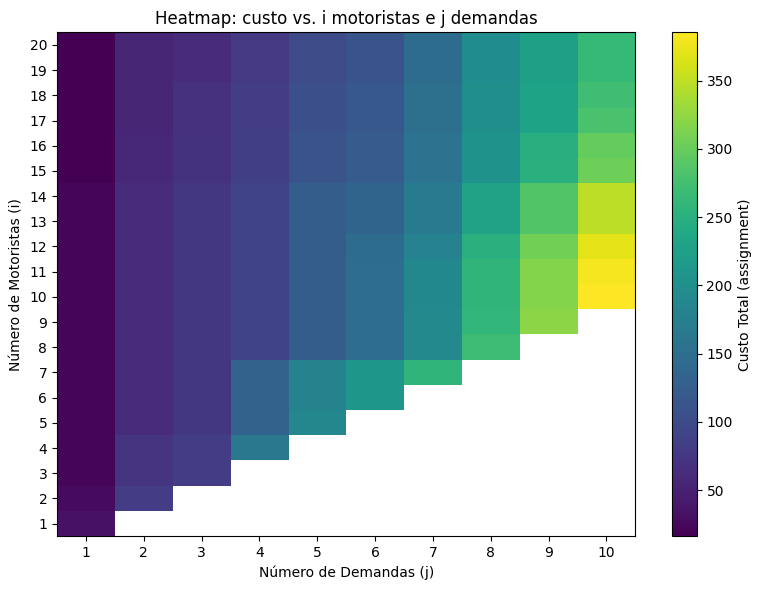

In [38]:
cost_mat = cost_table.to_numpy()
masked = np.ma.masked_invalid(cost_mat)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(masked, origin='lower', aspect='auto')
ax.set_xlabel('Número de Demandas (j)')
ax.set_ylabel('Número de Motoristas (i)')
ax.set_xticks(np.arange(n_demands)); ax.set_xticklabels(col_vals)
ax.set_yticks(np.arange(n_drivers)); ax.set_yticklabels(index_vals)
plt.colorbar(im, label='Custo Total (assignment)')
plt.title(f'Heatmap: custo vs. i motoristas e j demandas')
plt.tight_layout()
plt.show()

Conclusão:

- As células em branco $i<j$ (infactível).

- As cores vão escurecendo para a direita, pois o custo sobe com mais demandas.

- As cores vão clareando para cima, pois o custo baixa com mais motoristas.